## TASKS 1 & 3

In [1]:
from pandas import DataFrame,Series
import pandas as pd
import numpy as np

from sklearn import preprocessing,linear_model,ensemble,svm,grid_search
import sklearn.metrics

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#READ train.csv
#SPLIT into train and test (90% versus 10% sample)

raw = pd.read_csv("train.csv")
raw_train = raw.iloc[:len(raw.index)*9/10,:]
raw_test = raw.iloc[len(raw.index)*9/10:,:]

BENCHMARK MODEL:

1. Make a log transformation of the features
2. Make a 50% feature reduction by calculating pairwise logarithmically-transformed differences
3. Train a vanilla logistic model

Value of prediction is maintained: =1 means Person A more likely to be influence, =0 means Person B more likely to be influencer

In [3]:
# Log transformations
def log_trans(x):
    return np.log(x+1)  # +1 to take care of 0 values

# Train
features = raw_train.iloc[:,1:12].columns 
y_train = raw_train.iloc[:,0]
X_train_A = raw_train.iloc[:,1:12].as_matrix() #Person A
X_train_B = raw_train.iloc[:,12:].as_matrix() #Person B
X_train = log_trans(X_train_A) - log_trans(X_train_B) #Difference

#Logistic regression
model_logit = linear_model.LogisticRegression(fit_intercept = False)
model_logit.fit(X_train,y_train)

# Predict
y_test = raw_test.iloc[:,0]
X_test_A = raw_test.iloc[:,1:12].as_matrix()
X_test_B = raw_test.iloc[:,12:].as_matrix()
X_test = log_trans(X_test_A) - log_trans(X_test_B)
y_pred_lgt = model_logit.predict(X_test)

In [4]:
# Confusion matrix
cm_lgt = sklearn.metrics.confusion_matrix(y_test,y_pred_lgt)
cm_lgt

array([[213,  58],
       [ 57, 222]])

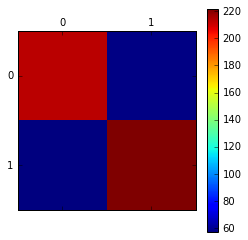

In [5]:
plt.matshow(cm_lgt)
plt.colorbar()

In [6]:
# REPORT Accuracy Score
accuracy_lgt = sklearn.metrics.accuracy_score(y_test,y_pred_lgt)
accuracy_lgt

0.79090909090909089

Reporting AUC score for ROC curve, instead of accuracy:

In [7]:
# AUC score of ROC curve
roc_auc_lgt = sklearn.metrics.roc_auc_score(y_test,y_pred_lgt)
roc_auc_lgt

0.79083839225489028

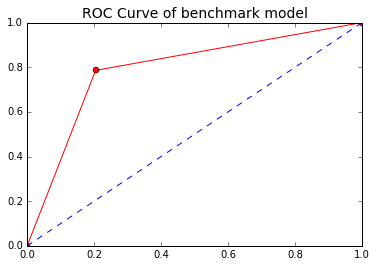

In [8]:
## Plot ROC curve
%matplotlib inline
tpr_lgt = 1.0 * cm_lgt[0,0]/(cm_lgt[0,0] + cm_lgt[0,1])
fpr_lgt = 1.0 * cm_lgt[1,0]/(cm_lgt[1,0] + cm_lgt[1,1])
plt.plot([0,fpr_lgt,1],[0,tpr_lgt,1],'ro-')
plt.plot([0,1],[0,1],'b--')
plt.axis([0,1,0,1])
plt.title("ROC Curve of benchmark model", size = 14)
plt.show()

However, in a symetric case where TPR and TNR are of equal interest we can just use accuracy score or AUC score of ROC curve
This is a symmetric case, and we will be using accuracy throughout

After calculating a baseline logisitic model, our goal is to learn additional classification models to see if accuracy can be improved, and to make further feature reduction.  

In order to do this, we trained a gradient boosting model with default values to make prediction and measure the importance of predictors.

In [9]:
model_gb = sklearn.ensemble.GradientBoostingClassifier(loss = 'exponential')
model_gb.fit(X_train,y_train)
y_pred_gb = model_gb.predict(X_test)
  ## Param:
   # loss = 'exponential'   - AdaBoost
   # max_depth = 3
   # learning_rate = 0.1
   # subsample = 1   - Global (Not Stochastic)
   # max_features = 11

In [10]:
# Confusion matrix
gb_lgt = sklearn.metrics.confusion_matrix(y_test,y_pred_gb)
gb_lgt

array([[215,  56],
       [ 53, 226]])

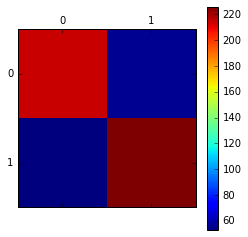

In [11]:
%matplotlib inline
plt.matshow(gb_lgt)
plt.colorbar()

In [12]:
## REPORT Accuracy Score
accuracy_gb = sklearn.metrics.accuracy_score(y_test,y_pred_gb) # 80.18%

Comparable accuracy to baseline logistic regression model

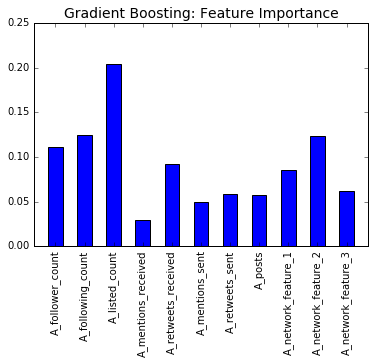

In [13]:
## PLOT Feature Importance
bar_width = 0.5
xtick_place = np.arange(0+bar_width/2,11+bar_width/2,1)

plt.bar(range(0,11),model_gb.feature_importances_, bar_width)
plt.xticks(xtick_place,features,rotation = 'vertical')
plt.xlim(-bar_width,10+2*bar_width)
plt.title("Gradient Boosting: Feature Importance",size=14)

Select Top 6 features: 
1. listed_count
2. following_count
3. follower_count
4. network_feature_2
5. retweets_received 
6. network_feature_1 

Intuitively, retweets_received seems important, as well as follower_count. In essence, follower_count is a social measure of influence.  On it's face, following_count would not seem to provide a measure of social influence - however, it could measure a degree of social interaction that could be important for influence.

We set the threshold at 6 features because we believe retweet_received matters, and network_feature_1 is of similar importance level to retweet_count. 

We trained a logistic regression model using these features to compare accuracy performance.

In [14]:
top_6 = [0,1,2,4,8,9]
X_train_6 = X_train[:,top_6] 
X_test_6 = X_test[:,top_6]

In [15]:
# Logistic (w/ param optimization)
model_logit_6 = linear_model.LogisticRegression(fit_intercept = False)
model_logit_6.fit(X_train_6,y_train)
y_pred_lgt_6 = model_logit_6.predict(X_test_6)

## REPORT Accuracy Score
accuracy_lgt_6 = sklearn.metrics.accuracy_score(y_test,y_pred_lgt_6) # 79.82%
accuracy_lgt_6

0.79818181818181821

Comparable accuracy to baseline logistic regression model

After training a GBM model using default value, we used gridsearch to optimize parameters.  The goal here is to see how much the baseline GBM model can be improved.

In [19]:
# Gradient Boosting (w/ param optimization)
params = {
          'n_estimators' : [100, 200, 300, 400, 500],
          'learning_rate' : [0.05, 0.08, 0.1, 0.2], 
          'max_depth' : [2,3,4,5],
         }

estimator_gb_6 = sklearn.ensemble.GradientBoostingClassifier(loss = 'exponential')
model_gb_6 = sklearn.grid_search.GridSearchCV(estimator_gb_6,param_grid = params)
model_gb_6.fit(X_train_6,y_train)
  ## Param:
   # loss = 'exponential'   - AdaBoost
   # n_estimators = 100
   # max_depth = 3
   # learning_rate = 0.1
   # subsample = 1   - Global (Not Stochastic)

y_pred_gb_6 = model_gb.predict(X_test_6)

ValueError: Number of features of the model must  match the input. Model n_features is 11 and  input n_features is 6 

In [ ]:
# REPORT GB Accuracy Score
accuracy_gb_6 = sklearn.metrics.accuracy_score(y_test,y_pred_gb_6) # 79.27%

This didn't generate a significant improvement in overall accuracy from either the baseline logistic model or the baseline GBM model. 

We also looked at learning an SVM model with parameter optimization.

In [ ]:
# SVM (w/ param optimization)
params_svm = {
              'kernel' : ('linear','rbf'),
              'C' : [1,10,100]
             }
X_train_6_n = sklearn.preprocessing.normalize(X_train_6,axis=0)
X_test_6_n = sklearn.preprocessing.normalize(X_test_6,axis=0)

estimator_svm_6 = sklearn.svm.SVC()
model_svm_6 = sklearn.grid_search.GridSearchCV(estimator_svm_6,params_svm)

model_svm_6.fit(X_train_6_n, y_train)
y_pred_svm_6 = model_svm_6.predict(X_test_6_n)

In [ ]:
# REPORT SVM Accuracy Score
accuracy_svm_6 = sklearn.metrics.accuracy_score(y_test,y_pred_svm_6) # 79.45%

SVM does not provide a marked improvement over baseline logistic.

### Conclusion:

Top 6 features: 
1. listed_count
2. following_count
3. follower_count
4. network_feature_2
5. retweets_received 
6. network_feature_1 

Our preferred model ended up being a baseline logistic regression with log-tranformed features, and reduced using gradient boosting.  Alternate deep learning models did not generate signficant accuracy improvements, so we selected the most straight-forward and interpretable model.

Accuracy: 79.82%

## TASK 4

In [ ]:
#Using the selected model above, we mapped an extra prediction column to the raw data set
raw_all_A = raw.iloc[:,1:12].as_matrix()
raw_all_B = raw.iloc[:,12:].as_matrix()
raw_all = log_trans(raw_all_A) - log_trans(raw_all_B)
raw_all_new = raw_all[:,top_6]
y_pred_all = model_logit_6.predict(raw_all_new)
raw['Prediction'] = y_pred_all

Without using analytics, expected revenue is calculated below.  Without analytics, you pay each person $1 to tweet once in support of your product.  Since there are two people per data row, your cost is length*2.

From a revenue perspective, your expected revenue is 0.1%*$50 of each person's followers if they are an influencer.

In [ ]:
cost = len(raw)*2
mask_0 = raw['Choice'] == 0 #Find the rows where B is the influencer
fol_B = sum(raw[mask_0]['B_follower_count'])  #sum B's followers
mask_1 = raw['Choice'] == 1
fol_A = sum(raw[mask_1]['A_follower_count'])
all_fol = fol_A + fol_B
rev_wo_analytics = all_fol * 0.001*50
rev_wo_analytics

Using analytics with a model of 80% accuracy score, expected revenue is calculated below.

Your cost is equivalent, because for each row you're selecting a single person of greater influence to give $2.  The expected return on correctly classified influencers is 0.15%, while the expected return on incorrectly classified influencers is still 0.

In [ ]:
mask_equal = raw['Choice'] == raw['Prediction']
raw_analytics = raw[mask_equal]
mask_0 = raw_analytics['Choice'] == 0 
fol_B = sum(raw_analytics[mask_0]['B_follower_count'])
mask_1 = raw_analytics['Choice'] == 1
fol_A = sum(raw_analytics[mask_1]['A_follower_count'])
all_fol_analytics = fol_A + fol_B
rev_w_analytics = all_fol_analytics * 0.0015*50
rev_w_analytics

Given perfect information, he maximum revenue that can be generated from Twitter is calculated below (100% accuracy).

In [ ]:
mask_0 = raw['Choice'] == 0 
fol_B = sum(raw[mask_0]['B_follower_count'])
mask_1 = raw['Choice'] == 1
fol_A = sum(raw[mask_1]['A_follower_count'])
all_fol = fol_A + fol_B
rev_perfect = all_fol * 0.0015*50
rev_perfect